In [1]:

from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import tidetools
import seaborn as sns

from salishsea_tools import (nc_tools,viz_tools)

from salishsea_tools.nowcast import analyze, research_VENUS

from matplotlib import animation

import datetime

%matplotlib inline

In [2]:
sns.set_style('whitegrid')

Define date range

In [3]:
start = datetime.datetime(2015,7,1)
end = datetime.datetime(2015,7,31)

numdays = (end-start).days
dates = [start + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]

In [4]:
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

Load files over date range

In [5]:
#subset
ist=250
ien=320
jst=420
jen=422
x=np.arange(ist,ien)
y=np.arange(jst,jen)
k=np.arange(0,40)

files = analyze.get_filenames(start,end,'1h','grid_U', results_home)
u, times = analyze.combine_files(files,'vozocrtx',k,y,x )
u=np.ma.masked_values(u,0)

e3u = mesh.variables['e3u'][0,:,y,x]
umask = mesh.variables['umask'][0,:,y,x]

depav_u = analyze.depth_average_mask(u,e3u,umask, 1)
print(u.shape)

depav_u=np.expand_dims(depav_u,1)
ubc = u-depav_u

(744, 40, 2, 70)


In [6]:
files = analyze.get_filenames(start,end,'1h','grid_V', results_home)
v, times = analyze.combine_files(files,'vomecrty',k,y,x )


e3v = mesh.variables['e3v'][0,:,y,x]
vmask = mesh.variables['vmask'][0,:,y,x]

depav_v = analyze.depth_average_mask(v,e3v,vmask, 1)
v=np.ma.masked_values(v,0)

print(v.shape)

depav_v=np.expand_dims(depav_v,1)
vbc = v-depav_v

(744, 40, 2, 70)


In [7]:
ubc, vbc = viz_tools.unstagger(ubc, vbc)

In [8]:
ke = 0.5*(ubc**2 +vbc**2)
gdept = mesh.variables['gdept'][0,:,y,x]
gdept = gdept[:,1:,1:]
xplot,_ = np.meshgrid(x[1:],gdept[:,0,0])

{'VENUS': {'Central': {'depth': 300, 'j': 424, 'i': 266, 'lat': 49.0401, 'lon': -123.4261}, 'ddl': {'depth': 150, 'j': 425, 'i': 284, 'lat': 49.0807167, 'lon': -123.3400617}, 'East': {'depth': 170, 'j': 416, 'i': 283, 'lat': 49.0419, 'lon': -123.3176}}, 'Vancouver': {'lat': 49.2827, 'lon': -123.1207}}


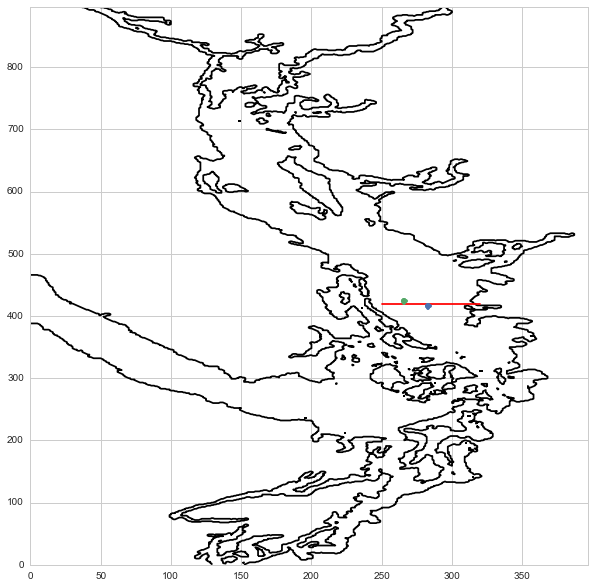

In [9]:
SITES = research_VENUS.SITES
print(SITES)
fig,ax=plt.subplots(1,1,figsize=(10,10))
viz_tools.plot_coastline(ax,bathy)
ax.plot([ist,ien], [jst,jst],'r')
ax.plot(SITES['VENUS']['East']['i'], SITES['VENUS']['East']['j'], 'o')
ax.plot(SITES['VENUS']['Central']['i'], SITES['VENUS']['Central']['j'],'o')

Testing out the size and colors before animating

In [10]:
def internal_tide(t):
    ax1.clear()
    #mesh
    m=ax1.contourf(xplot,gdept[:,0,:],ke[t,:,0,:],np.arange(0,.105,.005),cmap=cmap)

    #title and axxis
    timestamp = times[t]
    axm.set_title(timestamp.strftime('%d-%b-%Y %H:%M'))
    ax1.set_xlabel('y-postion')
    ax1.set_ylabel('depth[m]')
    ax1.set_ylim([300,0])
    ax1.set_xlim([ist,ien])
    
    return m

In [11]:
sns.set_context("notebook", rc={"lines.linewidth": .5})

In [12]:
print(ke.shape)

(744, 40, 1, 69)


In [13]:
gdept.shape

(40, 1, 69)

In [14]:
xplot.shape

(40, 69)

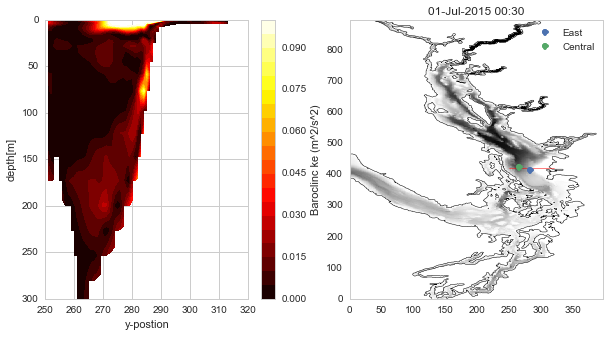

In [15]:
smin, smax, dels = 0, 34, 1
cs = np.arange(smin,smax)
cmap=plt.get_cmap('hot')
st=5

fig= plt.figure( figsize=(10, 5))
ax1=fig.add_subplot(1,2,1)
axm = fig.add_subplot(1,2,2)
t=0

m = internal_tide(0)
cbar = plt.colorbar(m, ax=ax1)
cbar.set_label('Baroclinc ke (m^2/s^2)')

viz_tools.plot_coastline(axm,bathy)
axm.pcolormesh(bathy.variables['Bathymetry'][:])
axm.plot([ist,ien], [jst,jst],'r')
axm.plot(SITES['VENUS']['East']['i'], SITES['VENUS']['East']['j'], 'o',label='East')
axm.plot(SITES['VENUS']['Central']['i'], SITES['VENUS']['Central']['j'],'o',label='Central')
axm.legend(loc=0)

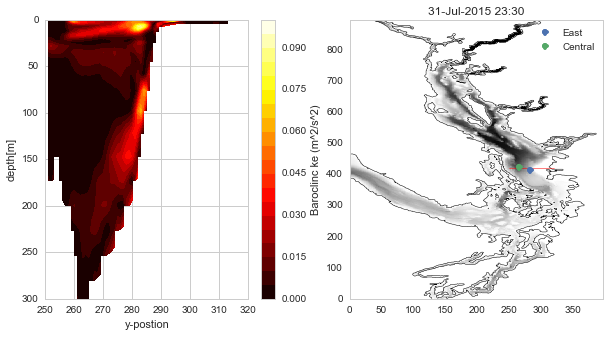

In [16]:
#Setting up first frame and static content
fig= plt.figure( figsize=(10, 5))
ax1=fig.add_subplot(1,2,1)
axm = fig.add_subplot(1,2,2)

mesh = internal_tide(0)
cbar = plt.colorbar(mesh, ax=ax1)
cbar.set_label('Baroclinc ke (m^2/s^2)')

viz_tools.plot_coastline(axm,bathy)
axm.pcolormesh(bathy.variables['Bathymetry'][:])
axm.plot([ist,ien], [jst,jst],'r')
axm.plot(SITES['VENUS']['East']['i'], SITES['VENUS']['East']['j'], 'o',label='East')
axm.plot(SITES['VENUS']['Central']['i'], SITES['VENUS']['Central']['j'],'o',label='Central')
axm.legend(loc=0)

#frmaes
framess=np.arange(1,ubc.shape[0])

#The animation function    
anim = animation.FuncAnimation(fig, internal_tide,frames=framess,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=3, bitrate=10000)

#Save in current folder
anim.save('internal_wave_beams_ke_jul2015.mp4',writer=mywriter)